In [1]:

import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-03-14 19:36:30--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.213.140.170, 2600:1417:3f:8a0::e59, 2600:1417:3f:898::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.213.140.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  17.7MB/s    in 46s     

2020-03-14 19:37:16 (16.9 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [0]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [0]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
  
  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[:testing_length]

  for filename in training_set:
      this_file = SOURCE + filename
      destination = TRAINING + filename
      copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE + filename
      destination = TESTING + filename
      copyfile(this_file, destination)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


11250
11250
1250
1250


In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), input_shape = (150,150, 3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
 98/225 [============>.................] - ETA: 1:32 - loss: 0.8782 - acc: 0.5462

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 189s 842ms/step - loss: 0.7600 - acc: 0.5753 - val_loss: 0.6353 - val_acc: 0.6468
Epoch 2/15
225/225 [==============================] - 178s 792ms/step - loss: 0.6256 - acc: 0.6567 - val_loss: 0.5867 - val_acc: 0.6892
Epoch 3/15
225/225 [==============================] - 179s 795ms/step - loss: 0.5844 - acc: 0.6876 - val_loss: 0.5610 - val_acc: 0.7160
Epoch 4/15
225/225 [==============================] - 178s 791ms/step - loss: 0.5639 - acc: 0.7088 - val_loss: 0.5499 - val_acc: 0.7220
Epoch 5/15
225/225 [==============================] - 179s 794ms/step - loss: 0.5415 - acc: 0.7249 - val_loss: 0.5269 - val_acc: 0.7508
Epoch 6/15
225/225 [==============================] - 180s 802ms/step - loss: 0.5234 - acc: 0.7368 - val_loss: 0.5724 - val_acc: 0.6856
Epoch 7/15
225/225 [==============================] - 179s 798ms/step - loss: 0.5181 - acc: 0.7424 - val_loss: 0.4816 - val_acc: 0.7632
Epoch 8/15
225/225 [==============================] - 179s 

Text(0.5, 1.0, 'Training and validation loss')

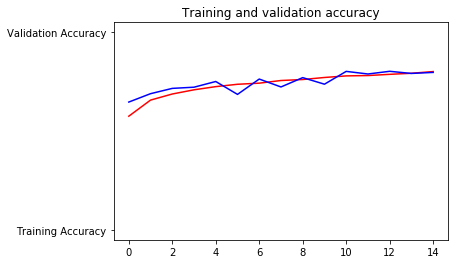

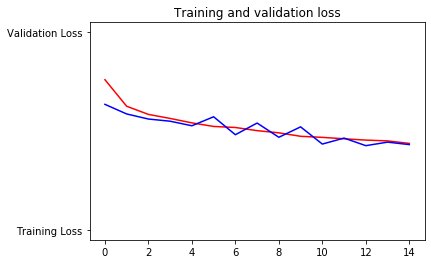

In [12]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')
